In [36]:
from datasets import load_dataset, concatenate_datasets, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import random
import os
from openai import OpenAI

# Initialize OpenAI client
client = OpenAI(api_key="KEY")

# 1. Load and merge train splits
dataset_ids = [
    "mdwiratathya/SLAKE-vqa-english",
    "flaviagiammarino/vqa-rad",
]
datasets_list = [load_dataset(ds_id, split="train") for ds_id in dataset_ids]
merge_dataset = concatenate_datasets(datasets_list)
print(f"Merged train dataset has {len(merge_dataset)} examples.")

# 2. Randomly sample 100 examples
sampled = merge_dataset.shuffle(seed=42).select(range(10))

# 3. Prepare augmentation outputs
new_rows = {"image": [], "question": [], "answer": []}

# 4. Paraphrasing function using ChatGPT 4.1 Nano
system_prompt = (
    "You are a medical VQA augmentation assistant. "
    "Generate semantically equivalent paraphrases of the user's question, "
    "preserving any medical terminology exactly."
)
num_paraphrases = 3

def generate_paraphrases(question: str) -> list[str]:
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Original question:\n{question}\n\nGenerate {num_paraphrases} paraphrases."}
    ]
    resp = client.chat.completions.create(
        model="gpt-4.1-nano",
        messages=messages,
        temperature=0.7,
        top_p=0.95,
        max_tokens=512
    )
    text = resp.choices[0].message.content
    paras = [p.strip() for p in text.split("\n") if p.strip()][:num_paraphrases]
    return paras

# 5. Image augmentation transforms
image_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.GaussianBlur(3),
])

# Helper to load PIL images
def pil_image(item):
    if isinstance(item, Image.Image):
        return item
    return Image.open(item)

# 6. Iterate with progress bar
for ex in tqdm(sampled, desc="Augmenting 100 samples"):
    img = pil_image(ex['image'])
    question = ex['question']
    answer = ex['answer']

    # Generate paraphrases via ChatGPT 4.1 Nano
    paraphrases = generate_paraphrases(question)

    # Output original and paraphrased questions
    print("Original question:", question)
    for idx, para in enumerate(paraphrases, 1):
        print(f"Paraphrase {idx}:", para)

    # Add each paraphrased question
    for para in paraphrases:
        new_rows['image'].append(img)
        new_rows['question'].append(para)
        new_rows['answer'].append(answer)

    # Apply image augmentation and add augmented image
    aug_img = image_transform(img)
    new_rows['image'].append(aug_img)
    new_rows['question'].append(question)
    new_rows['answer'].append(answer)

# 7. Create new dataset from augmented rows
augmented_dataset = Dataset.from_dict(new_rows)

# Merge with original and save
final_dataset = concatenate_datasets([merge_dataset, augmented_dataset])
print(f"Final merged dataset has {len(final_dataset)} examples.")
final_dataset.save_to_disk("./merge_dataset")


Merged train dataset has 6712 examples.


Augmenting 100 samples:  10%|█████▉                                                     | 1/10 [00:01<00:11,  1.33s/it]

Original question: How many organs are there in this image?
Paraphrase 1: 1. How many organs can be seen in this image?
Paraphrase 2: 2. What is the total number of organs depicted in this image?
Paraphrase 3: 3. How many organs are present in this image?


Augmenting 100 samples:  20%|███████████▊                                               | 2/10 [00:22<01:44, 13.05s/it]

Original question: In what plane is this image scanned?
Paraphrase 1: 1. Which plane was used to scan this image?
Paraphrase 2: 2. What anatomical plane is this image taken in?
Paraphrase 3: 3. In which plane is this image acquired?


Augmenting 100 samples:  30%|█████████████████▋                                         | 3/10 [00:43<01:57, 16.84s/it]

Original question: Which plane is the image scanned, transverse plane or coronal plane?
Paraphrase 1: 1. Is the image captured in the transverse plane or the coronal plane?
Paraphrase 2: 2. Does the scan depict the transverse plane or the coronal plane?
Paraphrase 3: 3. In which plane was the image taken: transverse or coronal?


Augmenting 100 samples:  40%|███████████████████████▌                                   | 4/10 [01:05<01:51, 18.63s/it]

Original question: How many existing lungs in this image?
Paraphrase 1: 1. How many lungs are visible in this image?
Paraphrase 2: 2. What is the count of lungs present in this image?
Paraphrase 3: 3. How many lungs can be seen in this picture?


Augmenting 100 samples:  50%|█████████████████████████████▌                             | 5/10 [01:06<01:02, 12.49s/it]

Original question: Where is/are the abnormality located?
Paraphrase 1: 1. What is the location of the abnormality?
Paraphrase 2: 2. Where can the abnormality be found?
Paraphrase 3: 3. In which area is the abnormality situated?


Augmenting 100 samples:  60%|███████████████████████████████████▍                       | 6/10 [01:29<01:03, 15.98s/it]

Original question: was this taken with good x ray penetration
Paraphrase 1: 1. Was this image captured using adequate X-ray penetration?
Paraphrase 2: 2. Did the X-ray achieve sufficient penetration for clear imaging?
Paraphrase 3: 3. Was the X-ray penetration quality sufficient for this image?


Augmenting 100 samples:  70%|█████████████████████████████████████████▎                 | 7/10 [01:50<00:53, 17.71s/it]

Original question: Is this image taken via X-Ray?
Paraphrase 1: 1. Was this image captured using an X-ray?
Paraphrase 2: 2. Is this an X-ray image?
Paraphrase 3: 3. Did they take this picture with an X-ray?


Augmenting 100 samples:  80%|███████████████████████████████████████████████▏           | 8/10 [02:12<00:37, 18.91s/it]

Original question: where are the hyperlucencies located?
Paraphrase 1: 1. In which areas are the hyperlucencies found?
Paraphrase 2: 2. Where can the hyperlucencies be observed?
Paraphrase 3: 3. What regions show the presence of hyperlucencies?


Augmenting 100 samples:  90%|█████████████████████████████████████████████████████      | 9/10 [02:34<00:19, 19.75s/it]

Original question: Is this an MRI image with T1 weighted?
Paraphrase 1: 1. Is this MRI image a T1-weighted scan?
Paraphrase 2: 2. Does this MRI image have T1 weighting?
Paraphrase 3: 3. Is the MRI image displayed here a T1-weighted image?


Augmenting 100 samples: 100%|██████████████████████████████████████████████████████████| 10/10 [02:55<00:00, 17.54s/it]

Original question: Does the trachea exist in this picture?
Paraphrase 1: 1. Is the trachea visible in this image?
Paraphrase 2: 2. Can you see the trachea in this picture?
Paraphrase 3: 3. Does this image show the trachea?
Final merged dataset has 6752 examples.


Saving the dataset (0/2 shards):   0%|          | 0/6752 [00:00<?, ? examples/s]

In [38]:
from datasets import load_from_disk

the_merged_dataset = load_from_disk("./merge_dataset")
print(the_merged_dataset)

Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 6752
})


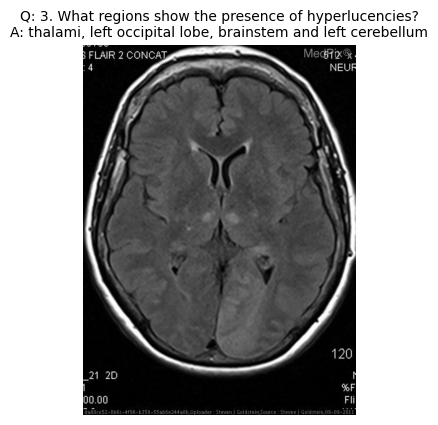

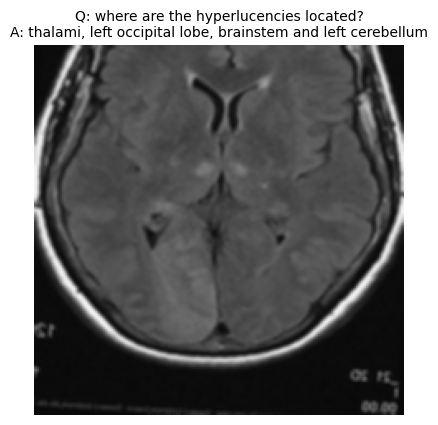

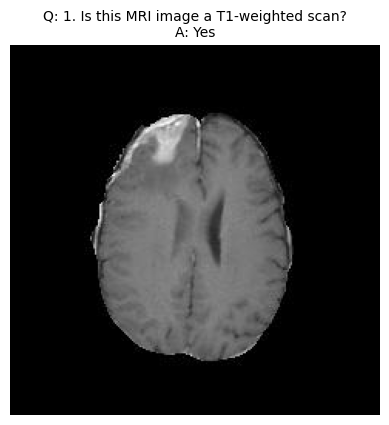

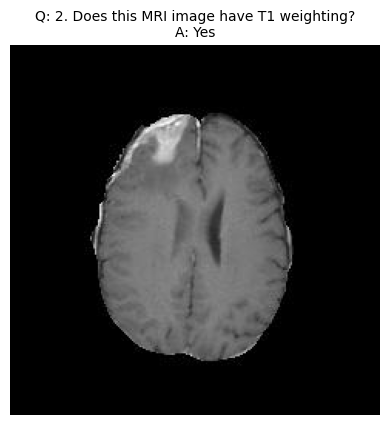

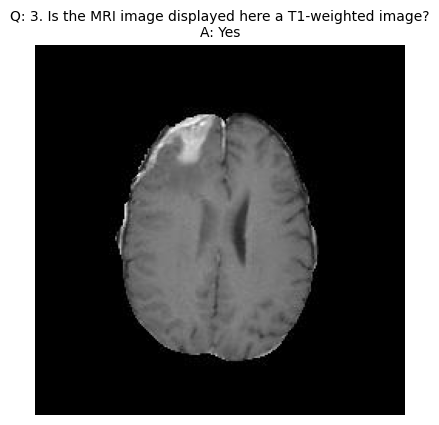

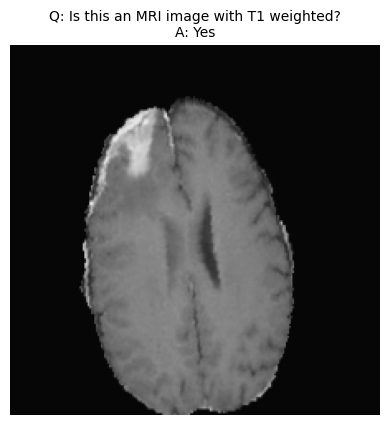

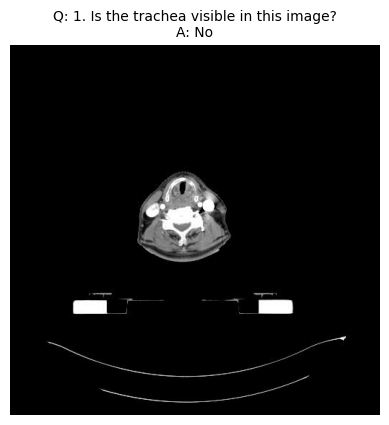

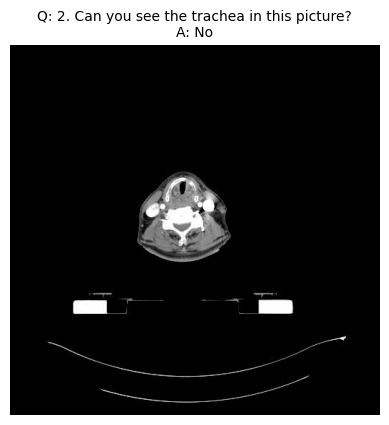

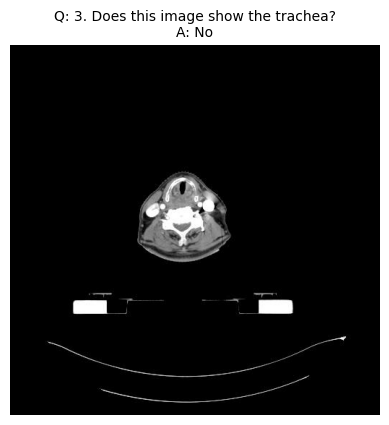

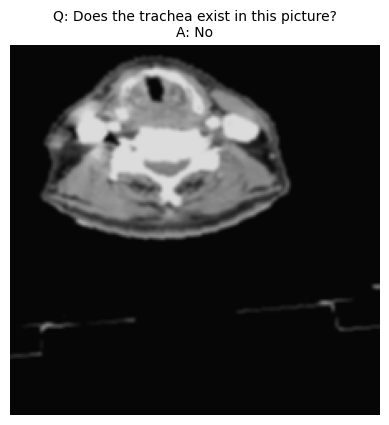

In [41]:
from datasets import load_from_disk
import matplotlib.pyplot as plt
from PIL import Image


num_rows = len(final_dataset)

last_five = final_dataset.select(range(num_rows-10, num_rows))

for item in last_five:
    image = item['image']
    
    if isinstance(image, dict) and 'path' in image:
        image = Image.open(image['path'])
    
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Q: {item['question']}\nA: {item['answer']}", fontsize=10)
    plt.show()